# Reducing overitting

Now that we've gotten the model to overfit, we can take a number of steps to reduce this.

In [1]:
%matplotlib inline
import utils
import importlib
importlib.reload(utils)
from utils import *
from __future__ import division, print_function

Using TensorFlow backend.


In [2]:
path = "/home/yinterian/data/dogscats/"
#path = "/home/yinterian/data/dogscats/sample/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Approaches to reducing overfitting

We do not necessarily need to rely on dropout or other regularization approaches to reduce overfitting. There are other techniques we should try first, since regularlization, by definition, biases our model towards simplicity - which we only want to do if we know that's necessary. This is the order that we recommend using for reducing overfitting (more details about each in a moment):

1. Add more data
2. Use data augmentation
3. Use architectures that generalize well
4. Add regularization
5. Reduce architecture complexity.

We'll assume that you've already collected as much data as you can, so step (1) isn't relevant (this is true for most Kaggle competitions, for instance). So the next step (2) is data augmentation. This refers to creating additional synthetic data, based on reasonable modifications of your input data. For images, this is likely to involve one or more of: flipping, rotation, zooming, cropping, panning, minor color changes.

Which types of augmentation are appropriate depends on your data. For regular photos, for instance, you'll want to use horizontal flipping, but not vertical flipping (since an upside down car is much less common than a car the right way up, for instance!)

We recommend *always* using at least some light data augmentation, unless you have so much data that your model will never see the same input twice.

## About data augmentation

Keras comes with very convenient features for automating data augmentation. You simply define what types and maximum amounts of augmentation you want, and keras ensures that every item of every batch randomly is changed according to these settings. Here's how to define a generator that includes data augmentation:

In [3]:
# dim_ordering='tf' uses tensorflow dimension ordering,
#   which is the same order as matplotlib uses for display.
# Therefore when just using for display purposes, this is more convenient
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, zoom_range=0.1, shear_range=0.15, 
       channel_shift_range=10., horizontal_flip=True)

Let's take a look at how this generator changes a single image (the details of this code don't matter much, but feel free to read the comments and keras docs to understand the details if you're interested).

In [4]:
# Create a 'batch' of a single image
img = np.expand_dims(ndimage.imread('cat.jpg'),0)
# Request the generator to create batches from this image
aug_iter = gen.flow(img)

In [6]:
# Get eight examples of these augmented images
aug_imgs = [next(aug_iter)[0].astype(np.float32) for i in range(8)]

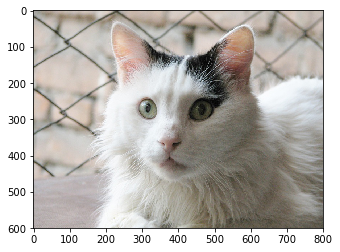

In [7]:
# The original
plt.imshow(img[0])

As you can see below, there's no magic to data augmentation - it's a very intuitive approach to generating richer input data. Generally speaking, your intuition should be a good guide to appropriate data augmentation, although it's a good idea to test your intuition by checking the results of different augmentation approaches.

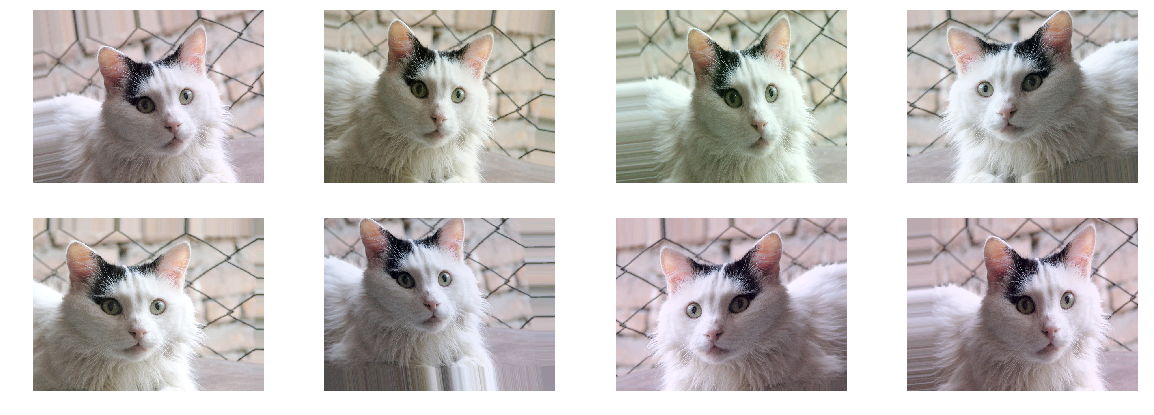

In [8]:
# Augmented data
plots(aug_imgs, (20,7), 2)

## Adding data augmentation

Let's try adding a small amount of data augmentation, and see if we reduce overfitting as a result. The approach will be identical to the method we used to finetune the dense layers in lesson 2, except that we will use a generator with augmentation configured. Here's how we set up the generator, and create batches from it:

In [9]:
# Import our class, and instantiate
import vgg16; importlib.reload(vgg16)
from vgg16 import vgg_preprocess

In [10]:
gen = image.ImageDataGenerator(preprocessing_function=vgg_preprocess, # to fit vgg16
                               rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [11]:
gen_val = image.ImageDataGenerator(preprocessing_function=vgg_preprocess)

In [12]:
batches = get_batches(path+'train', gen, batch_size=batch_size)
# NB: We don't want to augment or shuffle the validation set
val_batches = get_batches(path+'valid', gen_val, shuffle=False, batch_size=batch_size)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


When using data augmentation, we can't pre-compute our convolutional layer features, since randomized changes are being made to every input image. That is, even if the training process sees the same image multiple times, each time it will have undergone different data augmentation, so the results of the convolutional layers will be different.

In [13]:
vgg = Vgg16()
model = vgg.model

In [14]:
vgg.finetune(batches)
model = vgg.model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
model.load_weights(model_path+'finetune2.h5')

In [16]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7fae9852f6a0> False
<keras.layers.convolutional.Conv2D object at 0x7fae9852fb70> False
<keras.layers.convolutional.Conv2D object at 0x7faf26690b70> False
<keras.layers.pooling.MaxPooling2D object at 0x7fae985d0e10> False
<keras.layers.convolutional.Conv2D object at 0x7fae985280f0> False
<keras.layers.convolutional.Conv2D object at 0x7fae985d9518> False
<keras.layers.pooling.MaxPooling2D object at 0x7fae9850a5f8> False
<keras.layers.convolutional.Conv2D object at 0x7fae982bfb00> False
<keras.layers.convolutional.Conv2D object at 0x7fae982dae80> False
<keras.layers.convolutional.Conv2D object at 0x7fae982ebf98> False
<keras.layers.pooling.MaxPooling2D object at 0x7fae98216e48> False
<keras.layers.convolutional.Conv2D object at 0x7fae9823d080> False
<keras.layers.convolutional.Conv2D object at 0x7fae982517f0> False
<keras.layers.convolutional.Conv2D object at 0x7fae981e6fd0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fae9820feb8> Fa

In [17]:
for layer in model.layers[20:]: layer.trainable = True

Now we can compile, train, and save our model as usual - note that we use *fit_generator()* since we want to pull random images from the directories on every batch.

In [18]:
opt = RMSprop(lr=0.00001, rho=0.7)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(batches, steps_per_epoch=batches.samples/batches.batch_size, epochs=4, 
                    validation_data=val_batches, validation_steps=val_batches.samples/val_batches.batch_size)

Epoch 1/4
360/359 [==============================] - 191s - loss: 0.4294 - acc: 0.9730 - val_loss: 0.3456 - val_acc: 0.9775

In [20]:
model.fit_generator(batches, steps_per_epoch=batches.samples/batches.batch_size, epochs=4, 
                    validation_data=val_batches, validation_steps=val_batches.samples/val_batches.batch_size)

Epoch 1/4
360/359 [==============================] - 189s - loss: 0.3550 - acc: 0.9777 - val_loss: 0.2726 - val_acc: 0.9825

In [21]:
model.save_weights(model_path + 'finetune4b.h5')

In [22]:
model.load_weights(model_path + 'finetune4b.h5')

## Batch normalization

### About batch normalization

Batch normalization (*batchnorm*) is a way to ensure that activations don't become too high or too low at any point in the model. Adjusting activations so they are of similar scales is called *normalization*. Normalization is very helpful for fast training - if some activations are very high, they will saturate the model and create very large gradients, causing training to fail; if very low, they will cause training to proceed very slowly. Furthermore, large or small activations in one layer will tend to result in even larger or smaller activations in later layers, since the activations get multiplied repeatedly across the layers.

Prior to the development of batchnorm in 2015, only the inputs to a model could be effectively normalized - by simply subtracting their mean and dividing by their standard deviation. However, weights in intermediate layers could easily become poorly scaled, due to problems in weight initialization, or a high learning rate combined with random fluctuations in weights.

Batchnorm resolves this problem by normalizing each intermediate layer as well. The details of how it works are not terribly important (although I will outline them in a moment) - the important takeaway is that **all modern networks should use batchnorm, or something equivalent**. There are two reasons for this:
1. Adding batchnorm to a model can result in **10x or more improvements in training speed**
2. Because normalization greatly reduces the ability of a small number of outlying inputs to over-influence the training, it also tends to **reduce overfitting**.

As promised, here's a brief outline of how batchnorm works. As a first step, it normalizes intermediate layers in the same way as input layers can be normalized. But this on its own would not be enough, since the model would then just push the weights up or down indefinitely to try to undo this normalization. Therefore, batchnorm takes two additional steps:
1. Add two more trainable parameters to each layer - one to multiply all activations to set an arbitrary standard deviation, and one to add to all activations to set an arbitary mean
2. Incorporate both the normalization, and the learnt multiply/add parameters, into the gradient calculations during backprop.

This ensures that the weights don't tend to push very high or very low (since the normalization is included in the gradient calculations, so the updates are aware of the normalization). But it also ensures that if a layer does need to change the overall mean or standard deviation in order to match the output scale, it can do so.

### Adding batchnorm to the model

We can use nearly the same approach as before - but this time we'll add batchnorm layers (and dropout layers):

In [16]:
conv_layers[-1].output_shape[1:]

(512, 14, 14)

In [34]:
def get_bn_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(),
        Dense(4096, activation='relu'),
        Dropout(p),
        BatchNormalization(),
        Dense(1000, activation='softmax')
        ]

In [68]:
p=0.6

In [69]:
bn_model = Sequential(get_bn_layers(0.6))

In [70]:
bn_model.load_weights('/data/jhoward/ILSVRC2012_img/bn_do3_1.h5')

In [71]:
def proc_wgts(layer, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in layer.get_weights()]

In [72]:
for l in bn_model.layers: 
    if type(l)==Dense: l.set_weights(proc_wgts(l, 0.3, 0.6))

In [73]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable=False

In [74]:
bn_model.add(Dense(2,activation='softmax'))

In [75]:
bn_model.compile(Adam(), 'categorical_crossentropy', metrics=['accuracy'])

In [76]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 6s - loss: 0.1800 - acc: 0.9547 - val_loss: 0.1132 - val_acc: 0.9760
Epoch 2/8
23000/23000 [==============================] - 6s - loss: 0.1001 - acc: 0.9650 - val_loss: 0.1019 - val_acc: 0.9795
Epoch 3/8
23000/23000 [==============================] - 6s - loss: 0.0911 - acc: 0.9664 - val_loss: 0.1171 - val_acc: 0.9780
Epoch 4/8
23000/23000 [==============================] - 6s - loss: 0.0894 - acc: 0.9674 - val_loss: 0.1072 - val_acc: 0.9790
Epoch 5/8
23000/23000 [==============================] - 6s - loss: 0.0904 - acc: 0.9658 - val_loss: 0.0891 - val_acc: 0.9800
Epoch 6/8
23000/23000 [==============================] - 6s - loss: 0.0834 - acc: 0.9680 - val_loss: 0.0990 - val_acc: 0.9805
Epoch 7/8
23000/23000 [==============================] - 6s - loss: 0.0831 - acc: 0.9686 - val_loss: 0.0989 - val_acc: 0.9805
Epoch 8/8
23000/23000 [==============================] - 6s - loss: 0

In [77]:
bn_model.save_weights(model_path+'bn.h5')

In [44]:
bn_model.load_weights(model_path+'bn.h5')

In [78]:
bn_layers = get_bn_layers(0.6)
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

In [79]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: final_model.add(layer)

In [80]:
for l1,l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [81]:
final_model.compile(optimizer=Adam(), 
                    loss='categorical_crossentropy', metrics=['accuracy'])

In [82]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 282s - loss: 0.0855 - acc: 0.9677 - val_loss: 0.0609 - val_acc: 0.9830


In [83]:
final_model.save_weights(model_path + 'final1.h5')

In [84]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
23000/23000 [==============================] - 282s - loss: 0.0734 - acc: 0.9723 - val_loss: 0.0743 - val_acc: 0.9810
Epoch 2/4
23000/23000 [==============================] - 282s - loss: 0.0661 - acc: 0.9760 - val_loss: 0.0490 - val_acc: 0.9840
Epoch 3/4
23000/23000 [==============================] - 282s - loss: 0.0641 - acc: 0.9762 - val_loss: 0.0633 - val_acc: 0.9800
Epoch 4/4
23000/23000 [==============================] - 282s - loss: 0.0579 - acc: 0.9776 - val_loss: 0.0553 - val_acc: 0.9840


In [85]:
final_model.save_weights(model_path + 'final2.h5')

In [86]:
final_model.optimizer.lr=0.001

In [92]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=4, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/4
23000/23000 [==============================] - 282s - loss: 0.0509 - acc: 0.9810 - val_loss: 0.0748 - val_acc: 0.9835
Epoch 2/4
23000/23000 [==============================] - 282s - loss: 0.0480 - acc: 0.9833 - val_loss: 0.0755 - val_acc: 0.9830
Epoch 3/4
23000/23000 [==============================] - 282s - loss: 0.0538 - acc: 0.9807 - val_loss: 0.0596 - val_acc: 0.9850
Epoch 4/4
23000/23000 [==============================] - 282s - loss: 0.0453 - acc: 0.9834 - val_loss: 0.0616 - val_acc: 0.9860


In [ ]:
bn_model.save_weights(model_path + 'final3.h5')

# Improving Predictions

## Predicting with an ensemble of CNN

In [23]:
def load_cat_dog_model(model_path, file, batches):
    vgg = Vgg16()
    vgg.finetune(batches)
    model = vgg.model
    model.load_weights(model_path + file)
    return model

In [24]:
model1 = load_cat_dog_model(model_path, "finetune4b.h5", batches)
model2 = load_cat_dog_model(model_path, "finetune2.h5", batches)
model3 = load_cat_dog_model(model_path, "finetune4.h5", batches)

In [25]:
val_data = vgg.get_data(path+'valid')
val_classes = val_batches.classes

Found 2000 images belonging to 2 classes.


In [26]:
probs1 = model1.predict(val_data)
probs2 = model2.predict(val_data)
probs3 = model3.predict(val_data)

In [27]:
probs = (probs1 + probs2 + probs3)/3.0
probs[:10]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.]], dtype=float32)

In [28]:
preds = np.array([np.argmax(x) for x in probs])

In [29]:
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [30]:
np.sum(val_classes == preds)/2000

0.98399999999999999

In [32]:
preds1 = np.array([np.argmax(x) for x in probs1])
np.sum(val_classes == preds1)/2000

0.98499999999999999

In [33]:
preds2 = np.array([np.argmax(x) for x in probs2])
np.sum(val_classes == preds2)/2000

0.98050000000000004

In [34]:
preds3 = np.array([np.argmax(x) for x in probs3])
np.sum(val_classes == preds3)/2000

0.98350000000000004

## Predicting average from augmented images

In [35]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [36]:
val_data.shape

(2000, 224, 224, 3)

In [37]:
val_data[0].shape

(224, 224, 3)

In [38]:
aug_iter = gen.flow(np.expand_dims(val_data[0], 0))
aug_imgs = np.array([next(aug_iter)[0].astype(np.uint8) for i in range(9)])

In [39]:
aug_imgs.shape

(9, 224, 224, 3)

In [41]:
probs = model1.predict(aug_imgs)
np.mean(probs, axis=0)

array([ 1.,  0.], dtype=float32)

In [42]:
def get_prediction(i):
    aug_iter = gen.flow(np.expand_dims(val_data[i], 0))
    aug_imgs = np.array([next(aug_iter)[0].astype(np.float32) for i in range(9)])
    probs = model1.predict(aug_imgs)
    pred = np.mean(probs, axis=0)
    return np.argmax(pred)

In [43]:
preds = [get_prediction(i) for i in range(2000)]

In [203]:
np.sum(val_classes == preds)/2000

0.98499999999999999